# rumPOMDP

Rachel L Bedder (rlbedder@princeton.edu)

From public repository at https://github.com/RachelBedder/rumination_cogsci
v1. 05/16/2023

In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### IMPORT SOME STUFF
#import what is necessary and some things that may be unnecessary
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
import numpy as np
import pandas as pd
import random
import seaborn as sns
import math
from scipy import stats
from scipy.interpolate import griddata
import copy
import pickle
import itertools
import importlib
import os

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### NUMPY SETTINGS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.set_printoptions(precision = 2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### BESPOKE FUNCTIONS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
from build_object_rumPOMDP import * 
from convenience_functions_rumPOMDP import * 
from modelFunctions_rumPOMDP import * 
from sample_sequence_functions_rumPOMDP import * 
from rewards_rumPOMDP import * 
from hidden_states_rumPOMDP import * 
from qvalues_rumPOMDP import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### DEFINE FOLDER NAMES FOR SAVING OBJECTS AND FIGURES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
mainPath = './simulations/'

if not os.path.exists(mainPath): #...if it already exists, it will not make a new folder
    os.makedirs(mainPath)

subFolders = ['objects','figures'] #...define the subfolder names, we will make these later


# 0. Open a pickled object

Comment these cells out if you are running new simulations

In [2]:
simNames = get_subfolders(mainPath)
print(simNames) #...returns all the possible object folders

[]


In [ ]:
pickleJar = simNames[1] #...select which one you want to unscrew!

simList = pickle_shelf(mainPath+pickleJar, 'pickledObject.dat')

#...extract what you need into the workplace
allRewards = simList[0].allRewards
allCosts = simList[0].allCosts
ratioIdx = simList[0].ratioIdx
simDict = simList[0].simDict

figFolder = os.path.join(pickleJar, 'figures/')
objectFolder = os.path.join(pickleJar, 'objects/')

# 1. Create Objects for a range of hidden states (1D)

Select the observation distributions and reward functions for your simulation.

#### "hidden states:"

This will generate a list of objects (e.g. simList) each with different hidden states.
The function 'build_hidden_states' contains sets of standard deviations and distances between the means given different keyword strings.

"baseline" std ∈ [10:5:20], mean ∈ [10:5:20] <br>
"test" std ∈ [20:5:30], mean ∈ [10:5:20]

#### "rewards"

Given some base number (typically 100), the function 'rewards_hidden_states' will generate a matrix of rewards for each state given some string keyword.

"loss_correct": rewards always +100, loss for X2 A1 is -100. Losses for X1 A2 range between ratios of 0.25 and 8 in granuality of 0.25.
"gain_incorrect": losses always -100, gain for X2 A2 is +100. Gains for X1 A1 range between ratios of 0.25 and 8 in granuality of 0.25.

In [3]:
# simDict = {
#     "name": "gainIncorrect_baseline",
#     "rewards": "gain_incorrect",
#     "hidden states": "baseline"}

# simDict = {
#     "name": "lossIncorrect_baseline",
#     "rewards": "loss_incorrect",
#     "hidden states": "baseline"}

# simDict = {
#     "name": "gainCorrect_baseline",
#     "rewards": "gain_correct",
#     "hidden states": "baseline"}
    
simDict = {
    "name": "lossCorrect_baseline",
    "rewards": "loss_correct",
    "hidden states": "baseline"}


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### MAKE A FOLDER FOR THIS SIMULATION
#and respective subfolders
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
folderRandom = str(random.randrange(1000,9999))
simPath = mainPath+simDict["name"]+'_'+folderRandom#...define the path of the main folder

#...create the simulation main folder
if not os.path.exists(simPath): 
    os.makedirs(simPath)
    
#...create the subfolders within the main simulation folder
for subFolder in subFolders:
    subfolder_path = os.path.join(simPath, subFolder)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)
        
figFolder = os.path.join(simPath, 'figures/')
objectFolder = os.path.join(simPath, 'objects/')


baseline


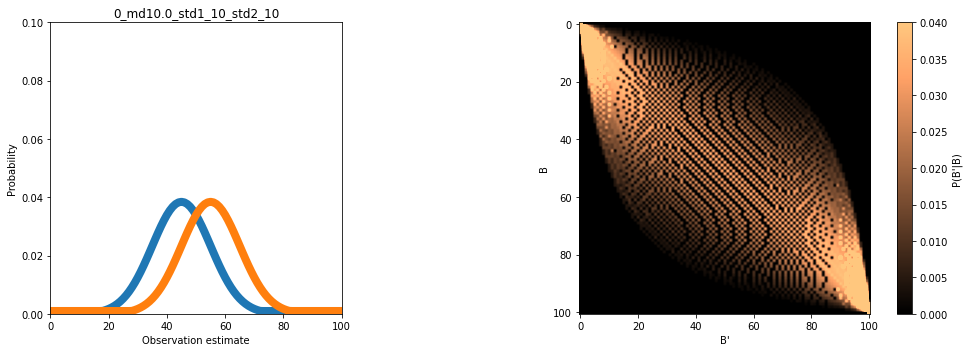

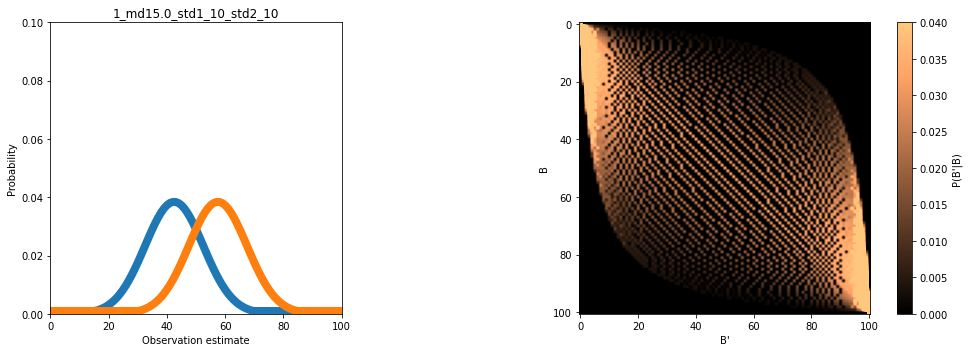

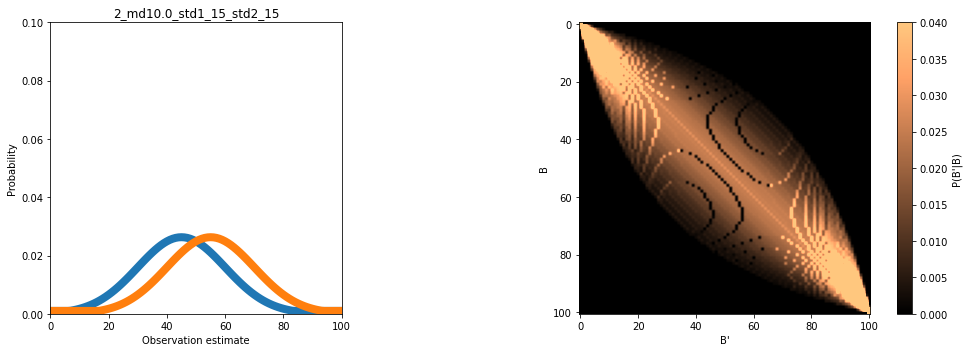

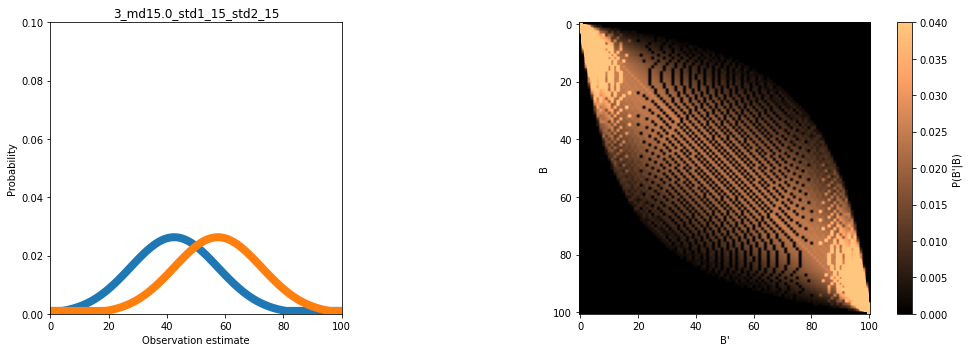

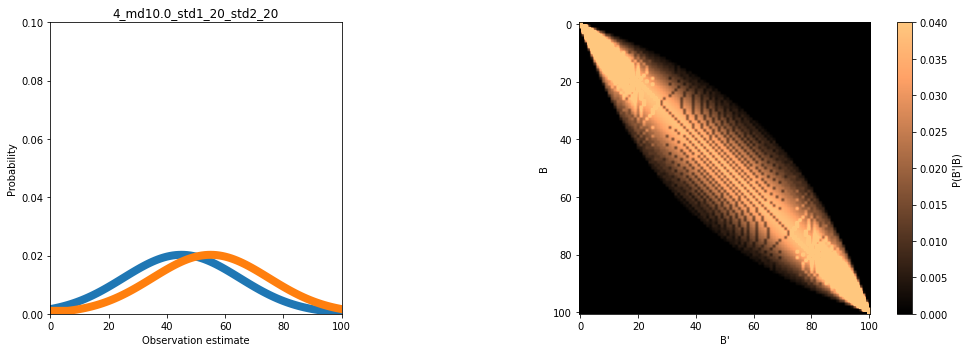

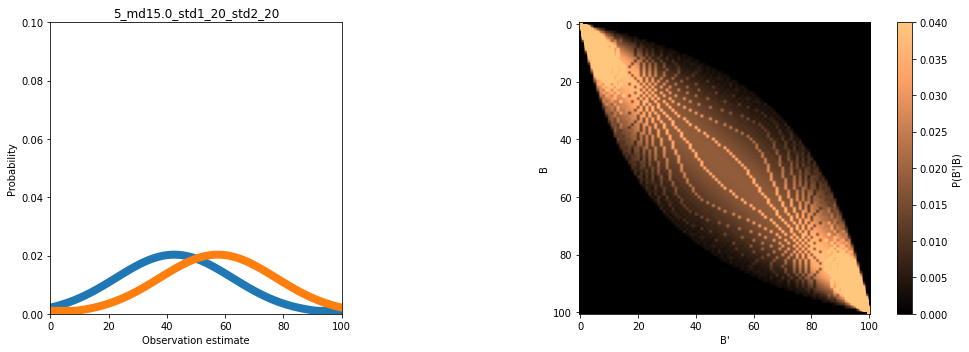

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### BUILD THE HIDDEN STATE OBSERVATION DISTRIBUTIONS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

xObvs = build_hidden_states(simDict["hidden states"])

obvStep = np.array([1]) #...this discretizes the observations which go from 1 to 100

simList = [] #...initialize a list to contain all the objects

for sim in xObvs:
    
    simList.append(POMDP(sim,obvStep)) 

for sim in simList:
    
    sim.simDict = simDict

    sim.belief_transition_matrix()
    sim.belief_transition_matrix_plot(figFolder) #...if you don't want to save these images just add an empty string here

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### BUILD THE REWARD FUNCTIONS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
baseNo = np.array([100])

allRewards,ratioIdx = rewards_hidden_states(simDict["rewards"],baseNo)

costRatios = np.array([0.00001,0.01,0.05])
allCosts = -costRatios*baseNo #...generate costs as a ratio of the base gain value

print(allRewards)
print(ratioIdx)
print(allRewards[:,ratioIdx[0]]/allRewards[:,ratioIdx[1]])

[[ 100.   -12.5 -100.   100. ]
 [ 100.   -25.  -100.   100. ]
 [ 100.   -50.  -100.   100. ]
 [ 100.  -100.  -100.   100. ]
 [ 100.  -200.  -100.   100. ]
 [ 100.  -400.  -100.   100. ]
 [ 100.  -800.  -100.   100. ]]
[1, 2]
[0.12 0.25 0.5  1.   2.   4.   8.  ]


finished value iteration


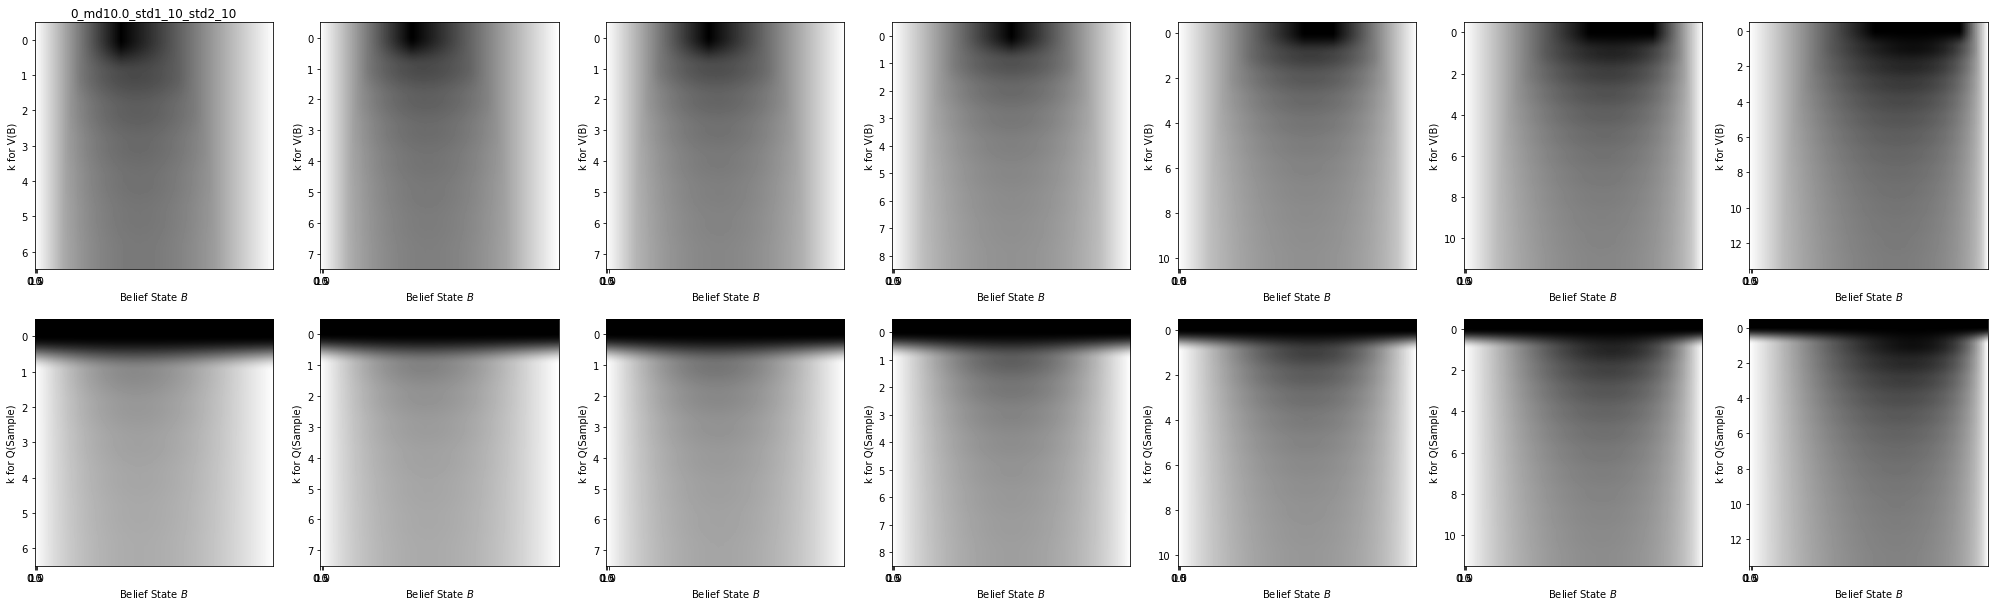

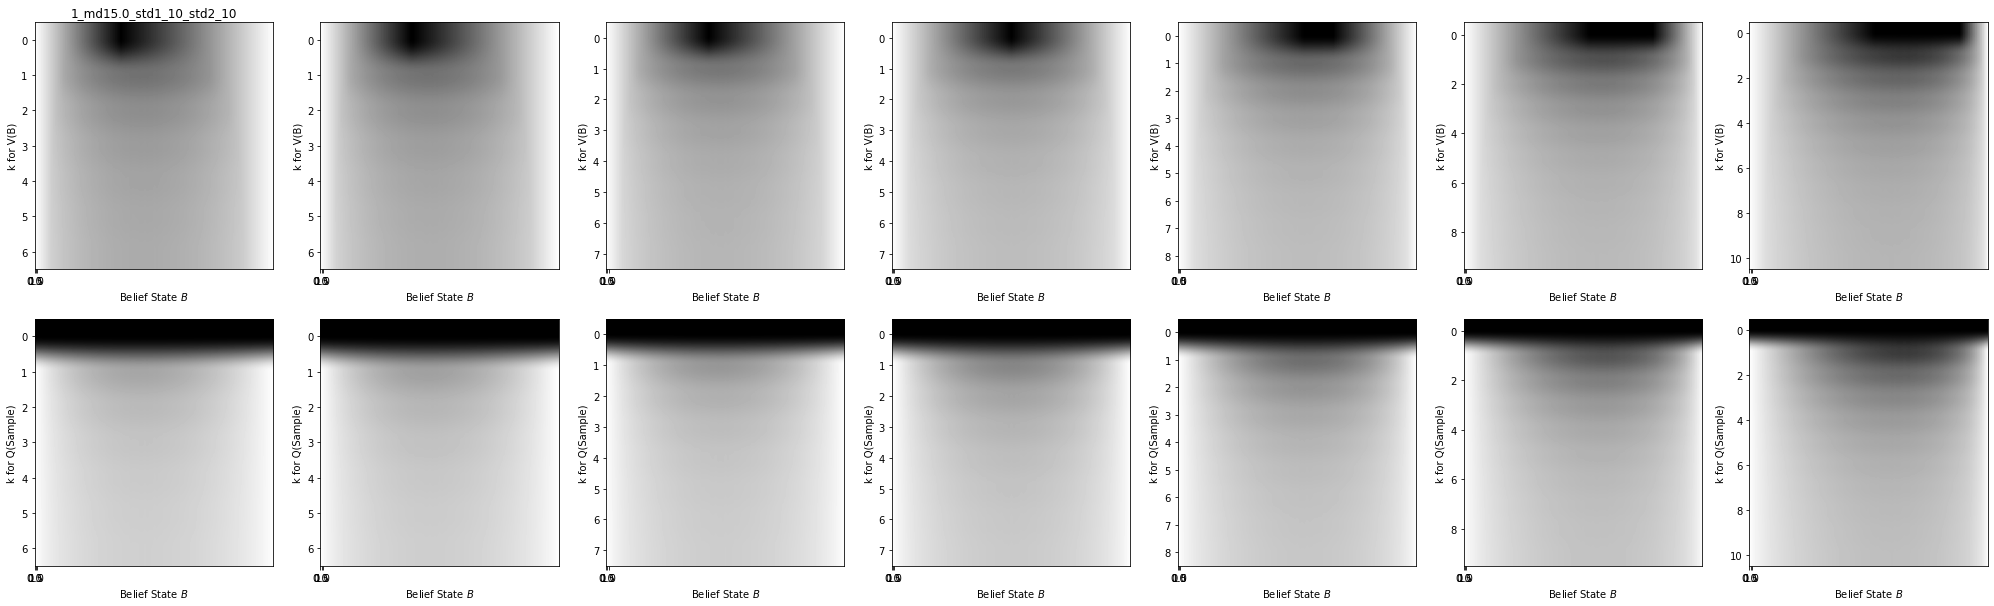

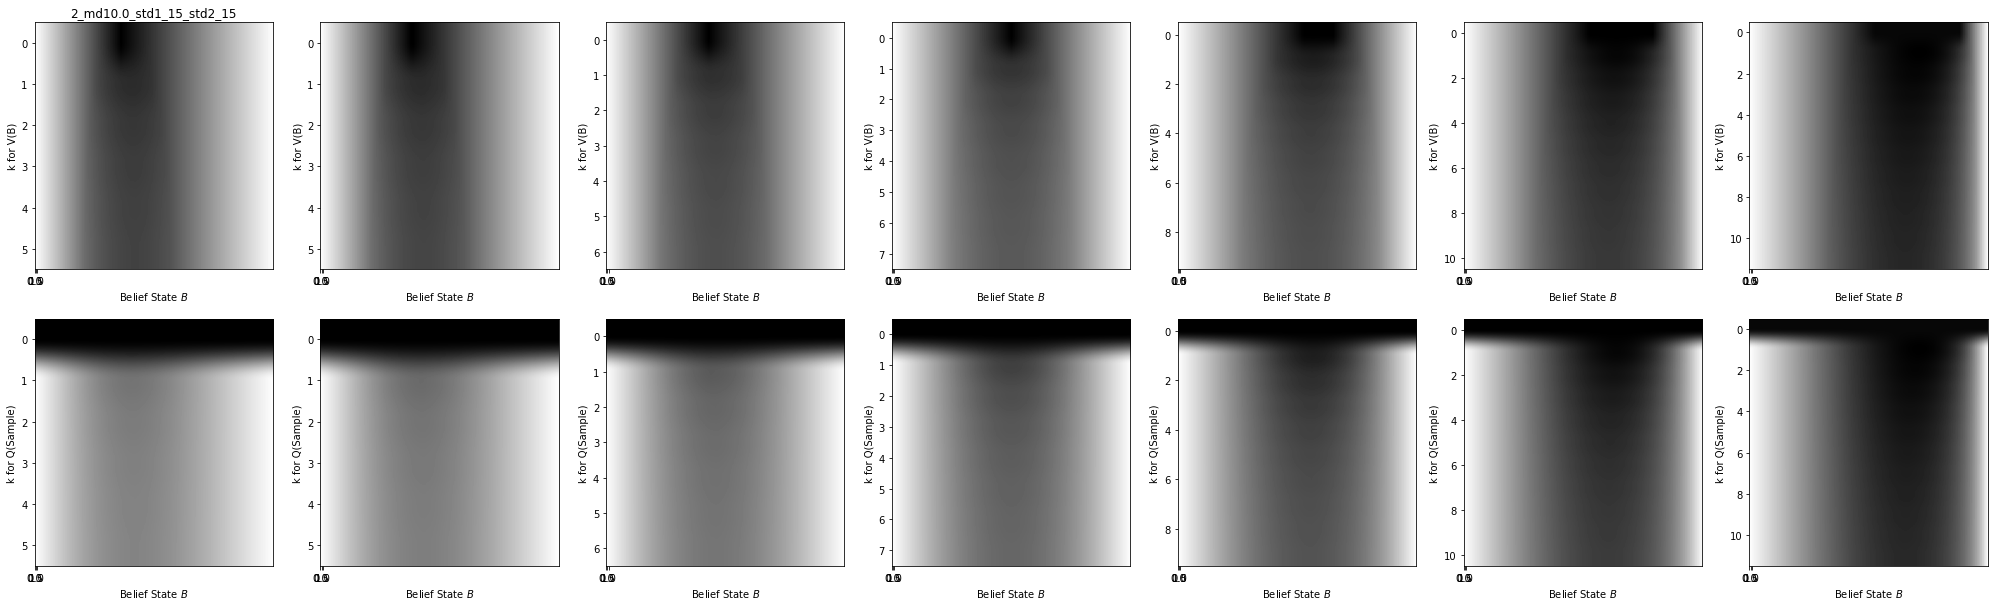

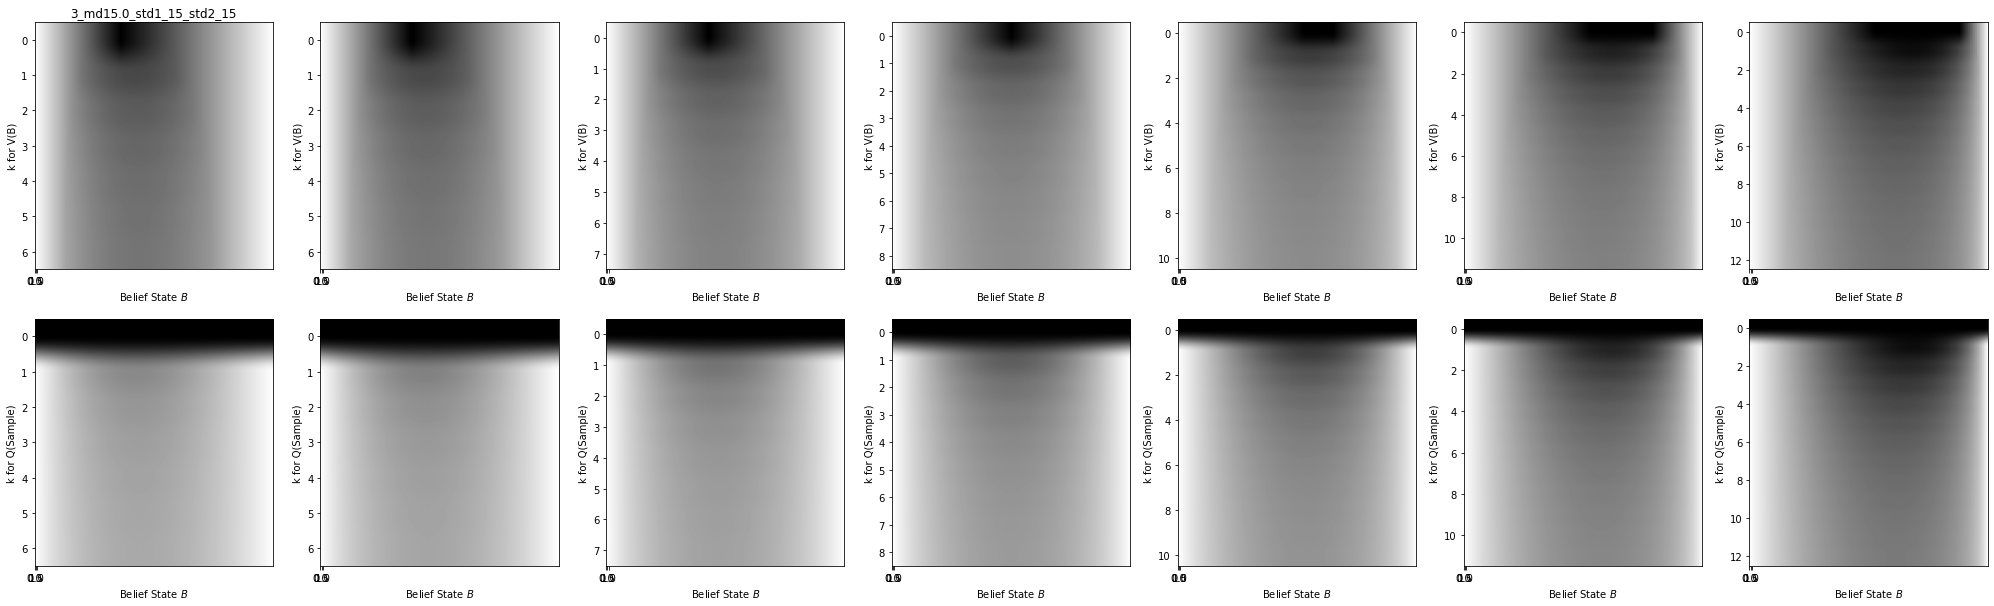

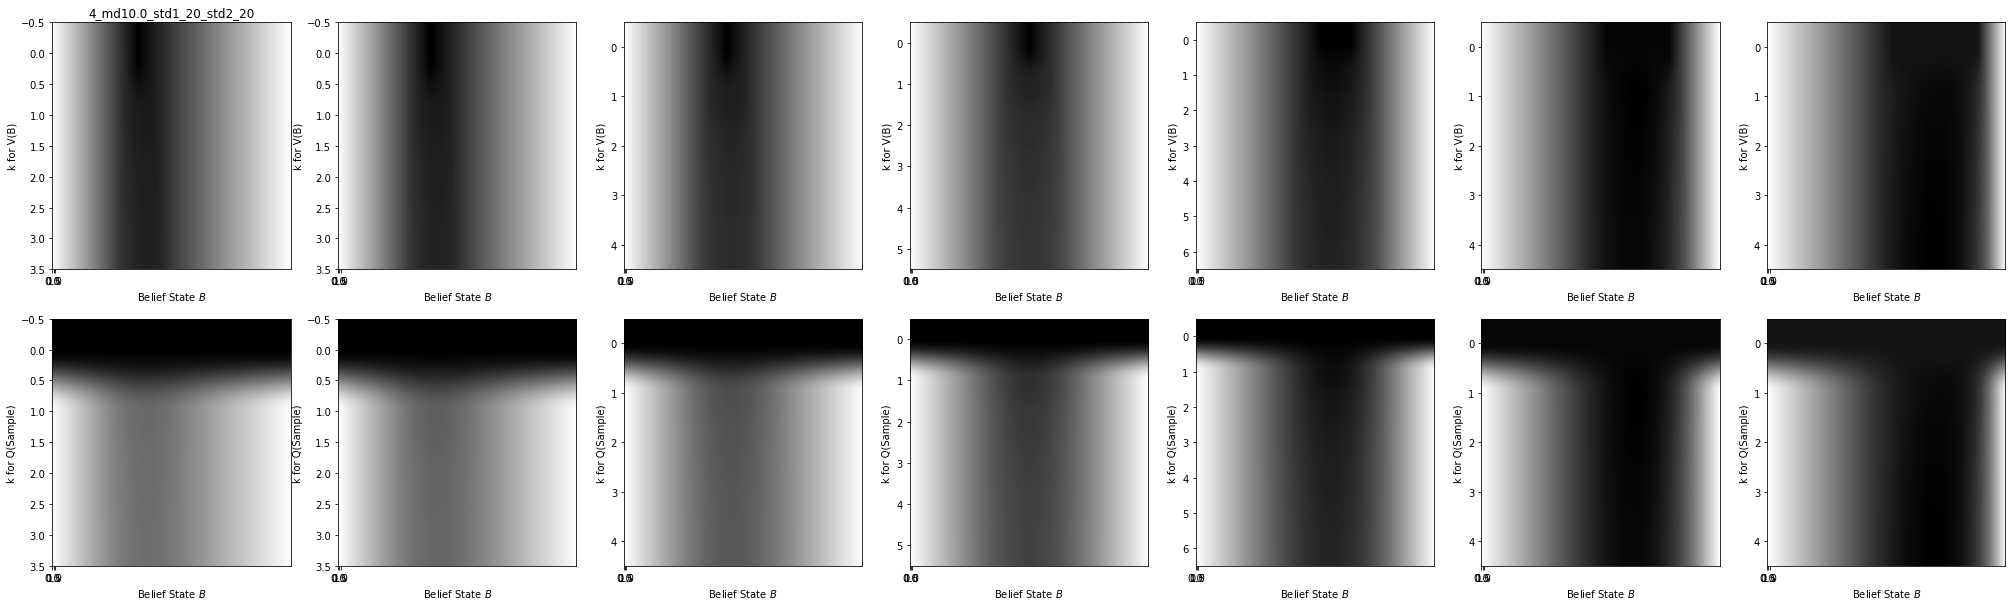

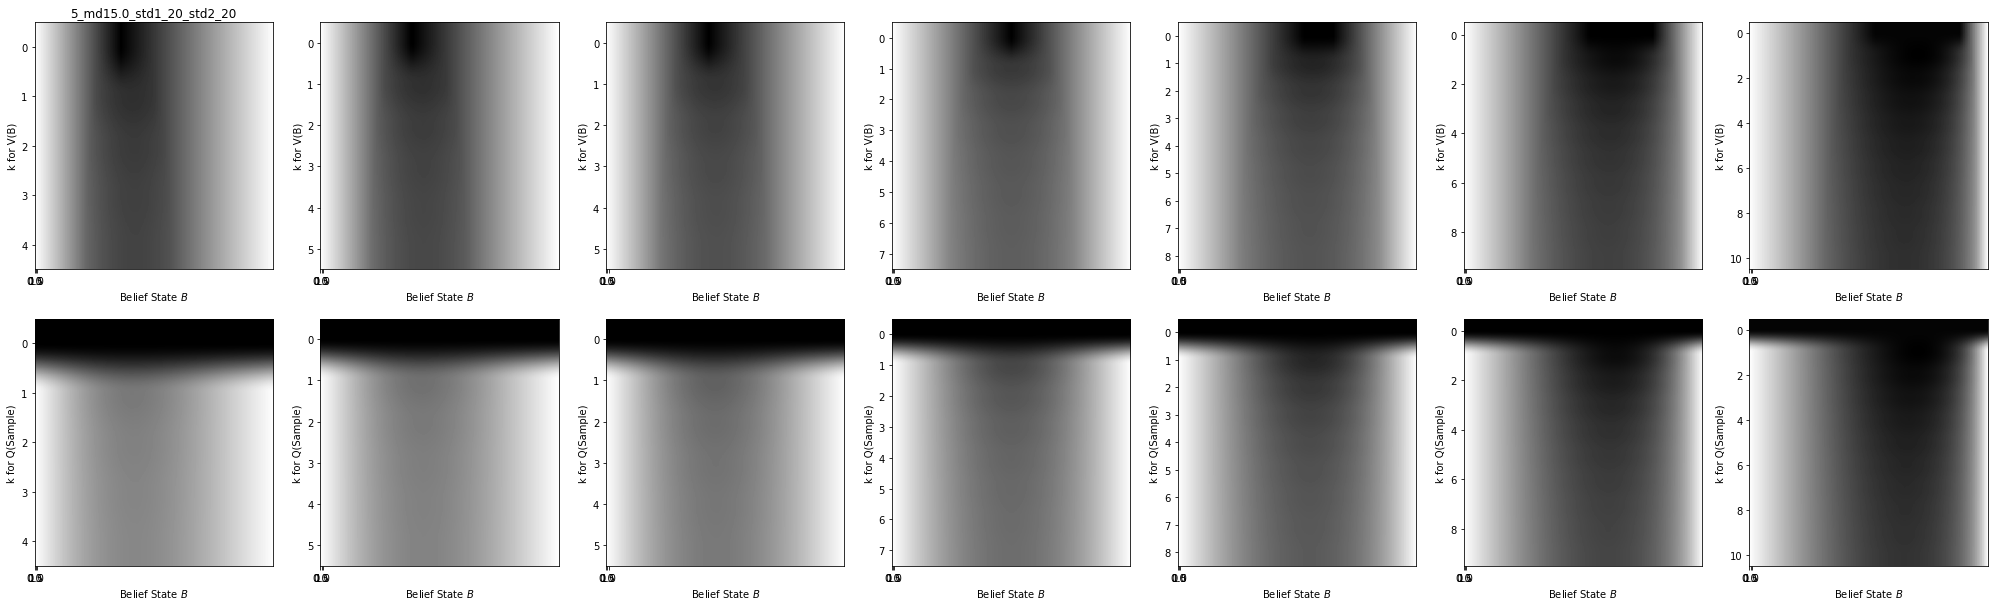

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### USE VALUE ITERATION TO FIND THE VALUES OF ALL BELIEF STATES AND ACTIONS UNDER THE OPTIMAL POLICY
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
figPrint = 'true' #...true if you want to see the value iteration plots

for sim in simList:
    sim.value_iteration(allRewards,allCosts,figPrint,figFolder)
    sim.ratioIdx = ratioIdx
print('finished value iteration')

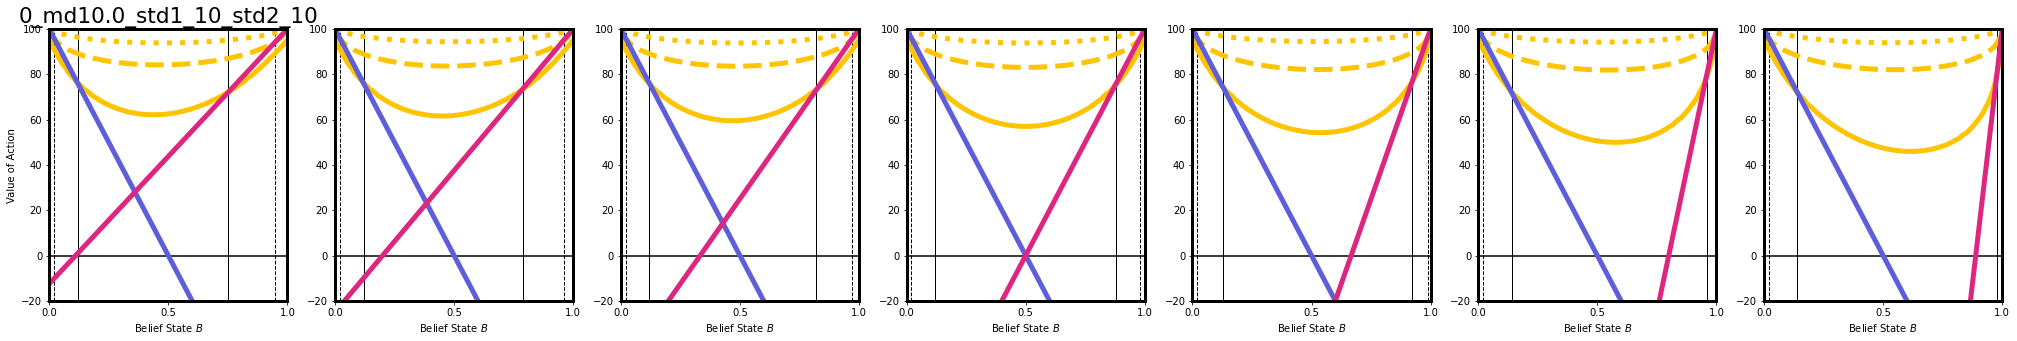

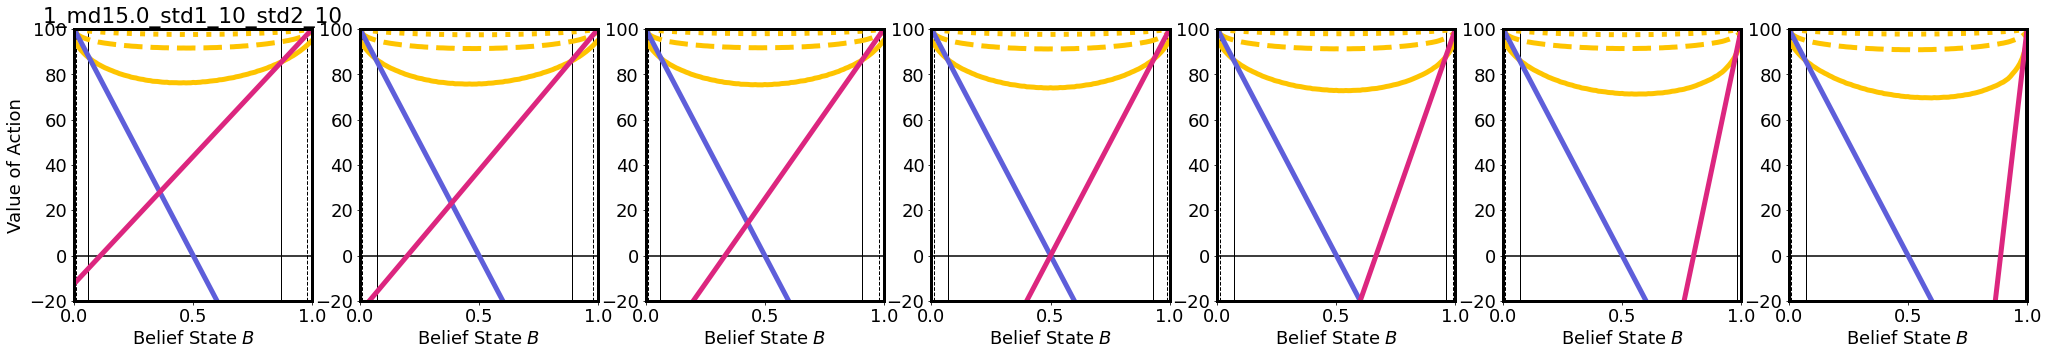

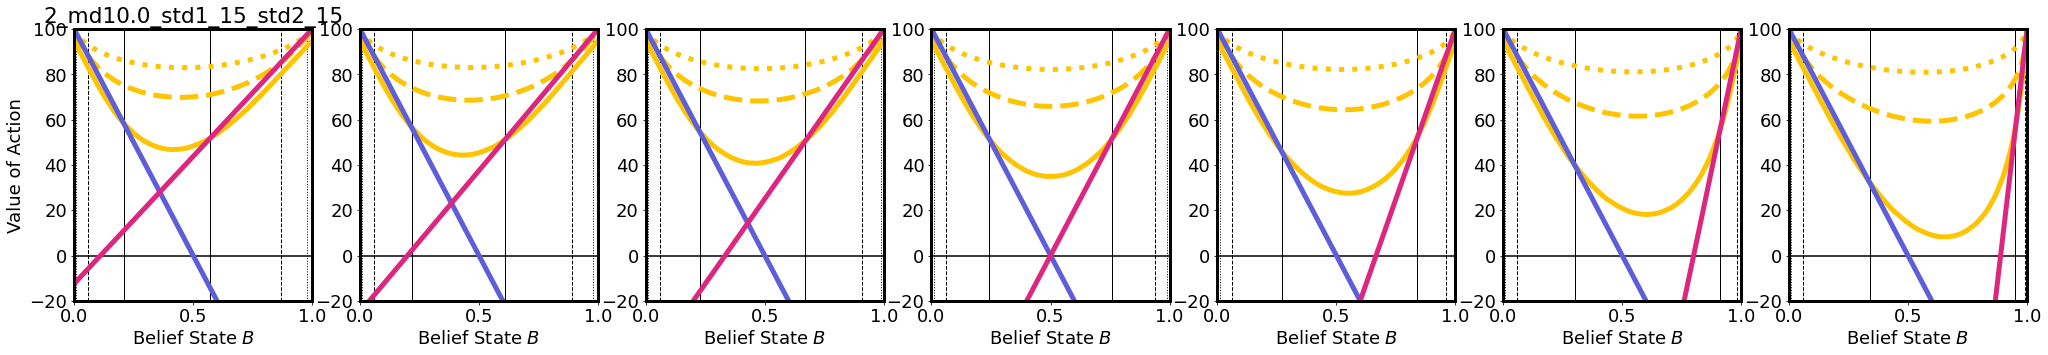

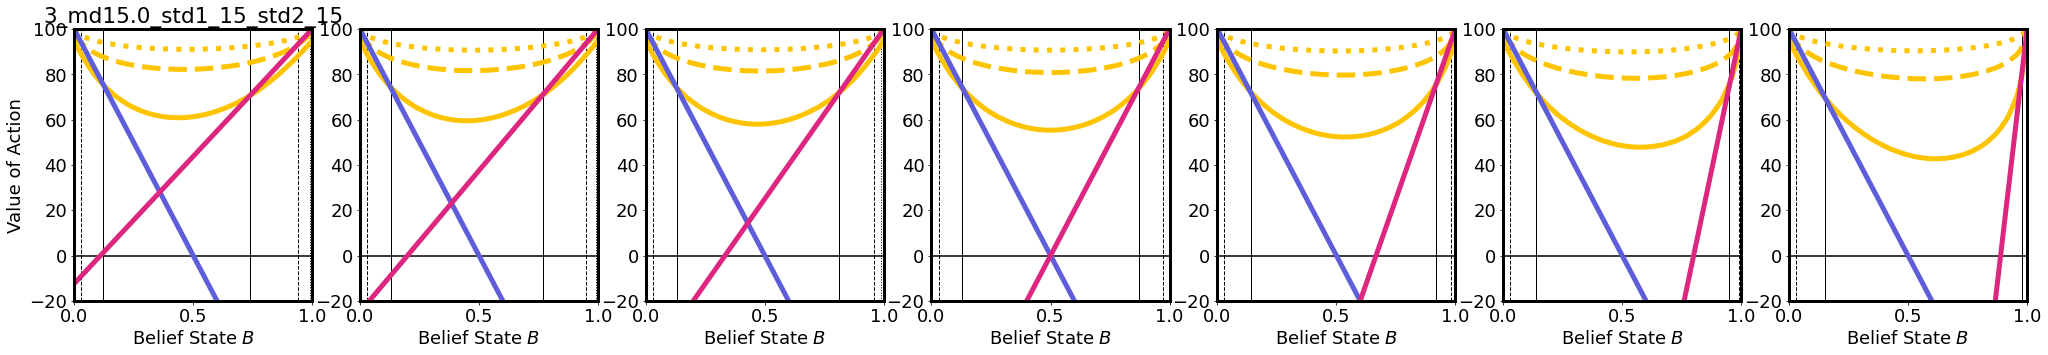

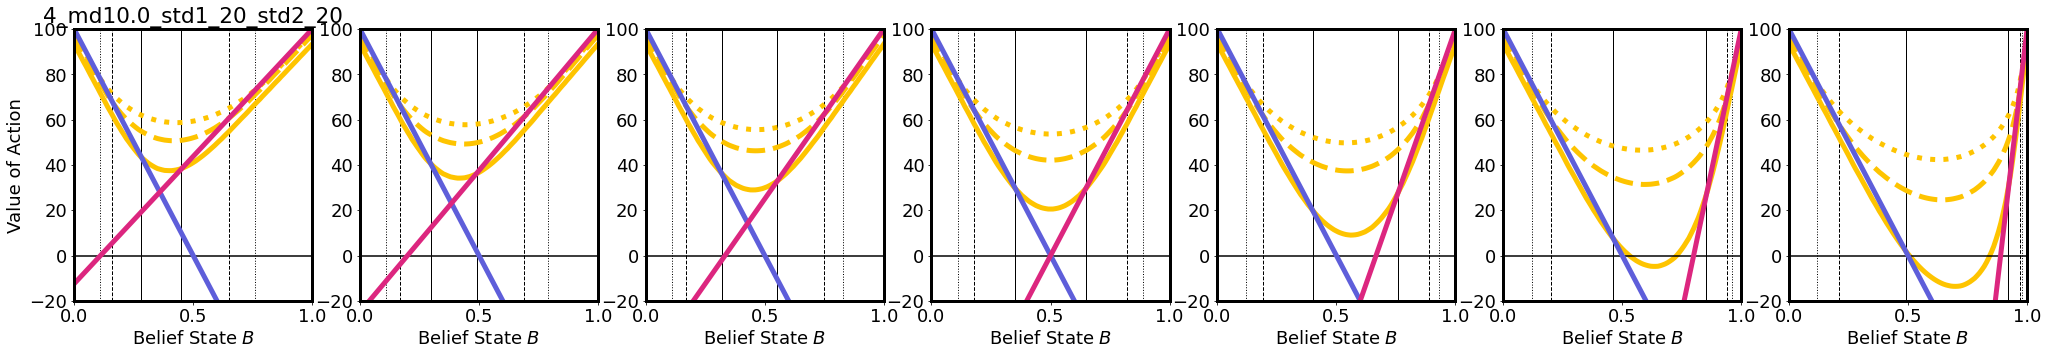

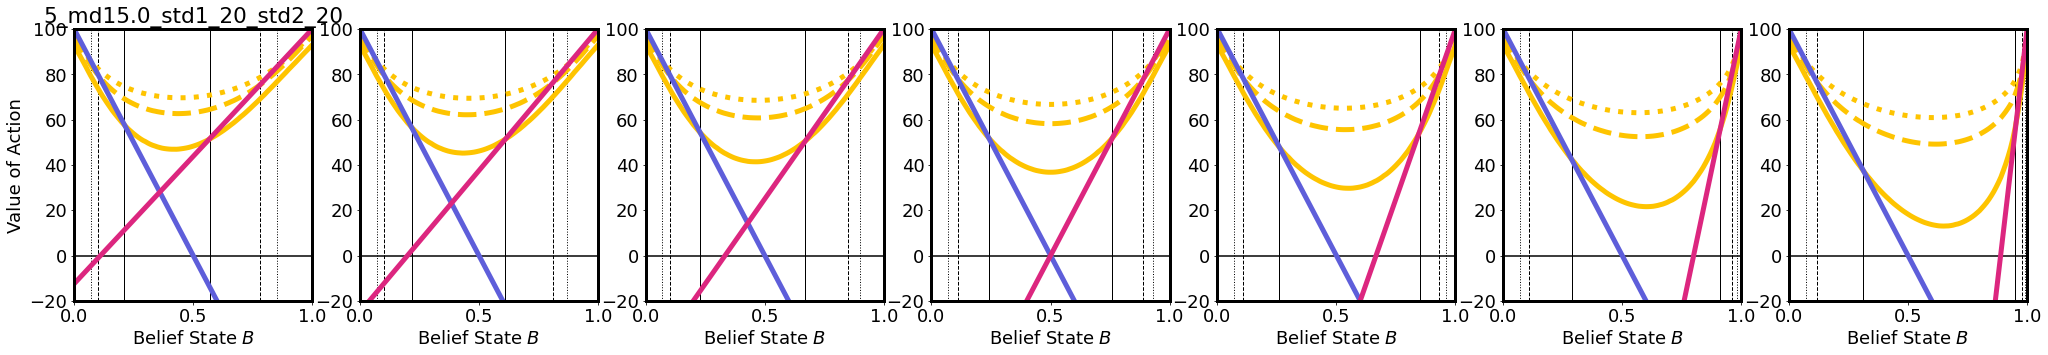

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### GENERATE SOME NICE PLOTS THE VALUES OF EACH ACTION IN EACH BELIEF STATE
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
rewardID = range(len(allRewards)) #...specify which rewards and costs you want to print for
costID = range(len(allCosts))
      
for sim in simList:
     qvalues_figure(sim,rewardID,costID,figFolder) 

# 3. Simulate accumulating information for each state and reward combination in the initial object list

Simulate various trials for each objects possible reward and costs.

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### SIMULATE A SERIES OF TRIALS FOR EACH SET OF STATES, REWARDS AND COSTS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
rewardID = range(len(allRewards))
costID = range(len(allCosts))
beliefStart = 0.5
maxSamples  = 100 #...maximum number of samples on each trial
noTrials = 20 #...number of independent trials/agents

obv_mismatch = "no_mismatch"

for sim in simList: #...Prints each column is a reward ratio, each row as different hidden states
        
        sample_sequence_observation_accumulated_cost(sim,allRewards,allCosts,rewardID,costID,beliefStart,maxSamples,noTrials,obv_mismatch)

/Users/rb1725/Documents/Repositories/rumination_cogsci/sample_sequence_functions_rumPOMDP.py:100: RuntimeWarning: Mean of empty slice
  self.noSamples_av[r,c,0] = np.nanmean(self.noSamples_t[r,c,self.termChoice_t[r,c,:]==0])


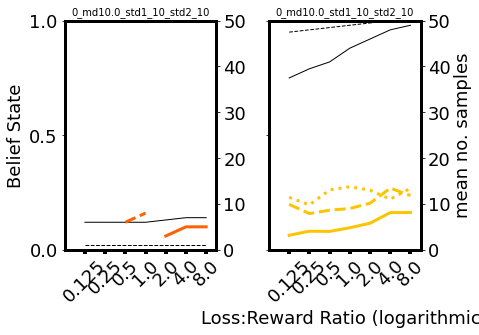

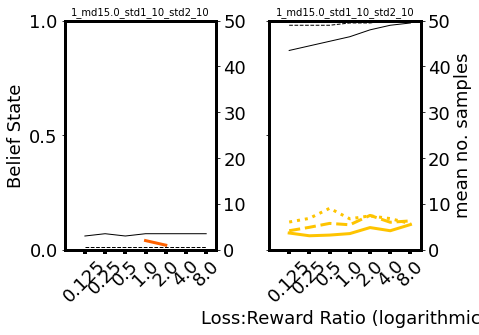

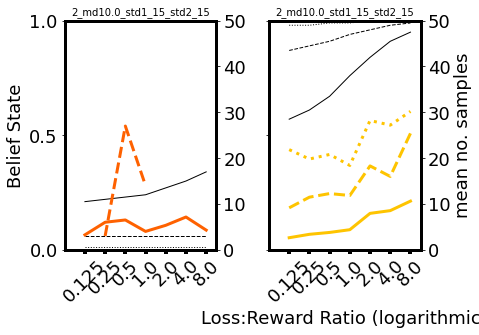

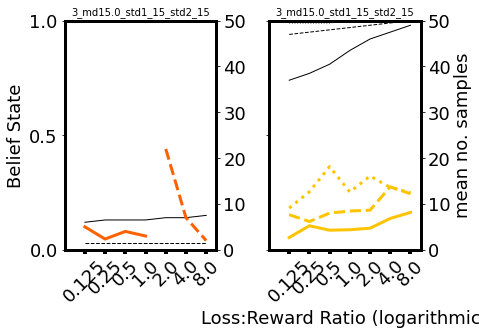

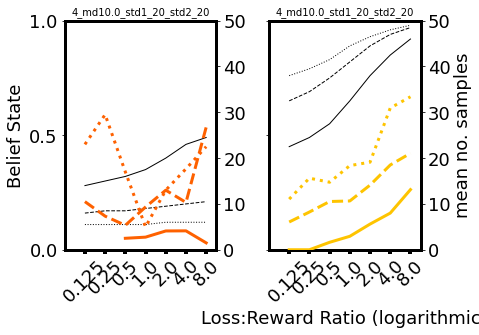

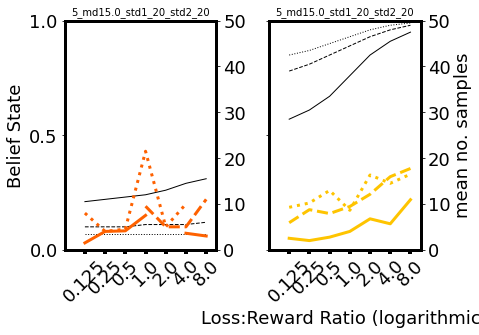

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### FIGURES FOR AVERAGE NUMBER OF SAMPLES TAKEN FOR EACH SET OF STATES, REWARDS AND COSTS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
rewardID = range(len(allRewards))
costID = range(len(allCosts))

for sim in simList: #...Prints each column is a reward ratio, each row as different hidden states
    sample_sequence_figure(sim,allRewards,allCosts,rewardID,costID,ratioIdx,figFolder)

# 4. Save the list of simulation objects

In [11]:
objectName = 'pickledObject'
PIK = (objectFolder+objectName+'.dat')
with open(PIK, "wb") as f:
    pickle.dump(simList, f) 